# Final Project: 某闯关类手游用户流失预测

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 一、案例简介

手游在当下的日常娱乐中占据着主导性地位，成为人们生活中放松身心的一种有效途径。近年来，各种类型的手游，尤其是闯关类的休闲手游，由于其对碎片化时间的利用取得了非常广泛的市场。然而在此类手游中，新用户流失是一个非常严峻的问题，有相当多的新用户在短暂尝试后会选择放弃，而如果能在用户还没有完全卸载游戏的时候针对流失可能性较大的用户施以干预（例如奖励道具、暖心短信），就可能挽回用户从而提升游戏的活跃度和公司的潜在收益，因此用户的流失预测成为一个重要且挑战性的问题。在毕业项目中我们将从真实游戏中非结构化的日志数据出发，构建用户流失预测模型，综合已有知识设计适合的算法解决实际问题。

## 二、作业说明

* 根据给出的实际数据（包括用户游玩历史，关卡特征等），预测测试集中的用户是否为流失用户（二分类）；
* 方法不限，使用百度云进行评测，评价指标使用 AUC；
* 提交代码与实验报告，报告展示对数据的观察、分析、最后的解决方案以及不同尝试的对比等；
* 最终评分会参考达到的效果以及对所尝试方法的分析。

## 三、数据概览

本次使用的是一个休闲类闯关手游的数据，用户在游戏中不断闯关，每一关的基本任务是在限定步数内达到某个目标。每次闯关可能成功也可能失败，一般情况下用户只在完成一关后进入下一关，闯关过程中可以使用道具或提示等帮助。

对大多数手游来说，用户流失往往发生在早期，因此次周的留存情况是公司关注的一个重点。本次数据选取了 2020.2.1 注册的所有用户在 2.1-2.4 的交互数据，数据经过筛选保证这些注册用户在前四日至少有两日登录。流失的定义则参照次周（2.7-2.13）的登录情况，如果没有登录为流失。

本次的数据和以往结构化的形式不同，展现的是更原始的数据记录，更接近公司实际日志的形式，共包含 5 个文件：

### train.csv

训练集用户，包括用户 id（从 1 开始）以及对应是否为流失用户的 label（1：流失，0：留存）。

In [ ]:
import pandas as pd
import numpy as np

train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/xtzx/proj/data/train.csv', sep='\t')
train_df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,8118,8119,8120,8121,8122,8123,8124,8125,8126,8127,8128,8129,8130,8131,8132,8133,8134,8135,8136,8137,8138,8139,8140,8141,8142,8143,8144,8145,8146,8147,8148,8149,8150,8151,8152,8153,8154,8155,8156,8157
user_id,2774,2775,2776,2777,2778,2779,2780,2781,2782,2783,2784,2785,2786,2787,2788,2789,2790,2791,2792,2793,2794,2795,2796,2797,2798,2799,2800,2801,2802,2803,2804,2805,2806,2807,2808,2809,2810,2811,2812,2813,...,10892,10893,10894,10895,10896,10897,10898,10899,10900,10901,10902,10903,10904,10905,10906,10907,10908,10909,10910,10911,10912,10913,10914,10915,10916,10917,10918,10919,10920,10921,10922,10923,10924,10925,10926,10927,10928,10929,10930,10931
label,0,0,1,0,1,1,0,0,0,1,0,1,1,0,1,0,0,0,1,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0,1,1,1,1,0,0,1,0,0,1,0,0,0,1,0,1,1,1,0,1,0,0,0,1,1,1,1,0,1,0


In [ ]:
train_df['label'].value_counts()

0    5428
1    2730
Name: label, dtype: int64

训练集共 8158 个用户，其中流失用户大约占 1/3，需要注意的是为了匿名化，这里数据都经过一定的非均匀抽样处理，流失率并不反映实际游戏的情况，用户与关卡的 id 同样经过了重编号，但对于流失预测任务来说并没有影响。

### dev.csv

验证集格式和训练集相同，主要为了方便离线测试与模型选择。

In [ ]:
dev_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/xtzx/proj/data/dev.csv', sep='\t')
dev_df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2618,2619,2620,2621,2622,2623,2624,2625,2626,2627,2628,2629,2630,2631,2632,2633,2634,2635,2636,2637,2638,2639,2640,2641,2642,2643,2644,2645,2646,2647,2648,2649,2650,2651,2652,2653,2654,2655,2656,2657
user_id,10932,10933,10934,10935,10936,10937,10938,10939,10940,10941,10942,10943,10944,10945,10946,10947,10948,10949,10950,10951,10952,10953,10954,10955,10956,10957,10958,10959,10960,10961,10962,10963,10964,10965,10966,10967,10968,10969,10970,10971,...,13550,13551,13552,13553,13554,13555,13556,13557,13558,13559,13560,13561,13562,13563,13564,13565,13566,13567,13568,13569,13570,13571,13572,13573,13574,13575,13576,13577,13578,13579,13580,13581,13582,13583,13584,13585,13586,13587,13588,13589
label,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,1,1,1,0,0,0,1,0,...,0,0,1,0,1,1,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1,1,0,1,0,0,0,1,0


### test.csv
测试集只包含用户 id，任务就是要预测这些用户的流失概率。

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/xtzx/proj/data/test.csv', sep='\t')
test_df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2733,2734,2735,2736,2737,2738,2739,2740,2741,2742,2743,2744,2745,2746,2747,2748,2749,2750,2751,2752,2753,2754,2755,2756,2757,2758,2759,2760,2761,2762,2763,2764,2765,2766,2767,2768,2769,2770,2771,2772
user_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,2734,2735,2736,2737,2738,2739,2740,2741,2742,2743,2744,2745,2746,2747,2748,2749,2750,2751,2752,2753,2754,2755,2756,2757,2758,2759,2760,2761,2762,2763,2764,2765,2766,2767,2768,2769,2770,2771,2772,2773


### level_seq.csv
这个是核心的数据文件，包含用户游玩每个关卡的记录，每一条记录是对某个关卡的一次尝试，具体每列的含义如下：

* `user_id`：用户 id，和训练、验证、测试集中的可以匹配；
* `level_id`：关卡 id；
* `f_success`：是否通关（1：通关，0：失败）；
* `f_duration`：此次尝试所用的时间（单位 s）；
* `f_reststep`：剩余步数与限定步数之比（失败为 0）；
* `f_help`：是否使用了道具、提示等额外帮助（1：使用，0：未使用）；
* `time`：时间戳。

In [ ]:
seq_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/xtzx/proj/data/level_seq.csv', sep='\t')
seq_df

,user_id,level_id,f_success,f_duration,f_reststep,f_help,time
0,10932,1,1,127.0,0.500000,0,2020-02-01 00:05:51
1,10932,2,1,69.0,0.703704,0,2020-02-01 00:08:01
2,10932,3,1,67.0,0.560000,0,2020-02-01 00:09:50
3,10932,4,1,58.0,0.700000,0,2020-02-01 00:11:16
4,10932,5,1,83.0,0.666667,0,2020-02-01 00:13:12
...,...,...,...,...,...,...,...
2194346,10931,40,1,111.0,0.250000,1,2020-02-03 16:26:37
2194347,10931,41,1,76.0,0.277778,0,2020-02-03 16:28:06
2194348,10931,42,0,121.0,0.000000,1,2020-02-03 16:30:17
2194349,10931,42,0,115.0,0.000000,0,2020-02-03 16:33:40


### level_meta.csv
每个关卡的一些统计特征，可用于表示关卡，具体每列的含义如下：

* `f_avg_duration`：平均每次尝试花费的时间（单位 s，包含成功与失败的尝试）；
* `f_avg_passrate`：平均通关率；
* `f_avg_win_duration`：平均每次通关花费的时间（单位 s，只包含通关的尝试）；
* `f_avg_retrytimes`：平均重试次数（第二次玩同一关算第 1 次重试）；
* `level_id`：关卡 id，可以和 level_seq.csv 中的关卡匹配。

In [ ]:
meta_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/xtzx/proj/data/level_meta.csv', sep='\t')
meta_df

,f_avg_duration,f_avg_passrate,f_avg_win_duration,f_avg_retrytimes,level_id
0,39.889940,0.944467,35.582757,0.017225,1
1,60.683975,0.991836,56.715706,0.004638,2
2,76.947355,0.991232,71.789943,0.004480,3
3,58.170347,0.993843,54.842882,0.004761,4
4,101.784577,0.954170,85.650547,0.027353,5
...,...,...,...,...,...
1504,594.878788,0.453730,133.625000,3.187500,1505
1505,486.562500,0.454180,115.906250,3.218750,1506
1506,325.968750,0.573525,86.250000,2.687500,1507
1507,793.096774,0.322684,164.000000,5.419355,1508


In [ ]:
seq_df=pd.merge(seq_df,meta_df,how='left')
seq_df

,user_id,level_id,f_success,f_duration,f_reststep,f_help,time,f_avg_duration,f_avg_passrate,f_avg_win_duration,f_avg_retrytimes,date
0,10932,1,1,127.0,0.500000,0,2020-02-01 00:05:51,39.889940,0.944467,35.582757,0.017225,2020-02-01
1,10932,2,1,69.0,0.703704,0,2020-02-01 00:08:01,60.683975,0.991836,56.715706,0.004638,2020-02-01
2,10932,3,1,67.0,0.560000,0,2020-02-01 00:09:50,76.947355,0.991232,71.789943,0.004480,2020-02-01
3,10932,4,1,58.0,0.700000,0,2020-02-01 00:11:16,58.170347,0.993843,54.842882,0.004761,2020-02-01
4,10932,5,1,83.0,0.666667,0,2020-02-01 00:13:12,101.784577,0.954170,85.650547,0.027353,2020-02-01
...,...,...,...,...,...,...,...,...,...,...,...,...
2194346,10931,40,1,111.0,0.250000,1,2020-02-03 16:26:37,182.560916,0.747221,95.003516,0.401055,2020-02-03
2194347,10931,41,1,76.0,0.277778,0,2020-02-03 16:28:06,154.543525,0.771965,88.825894,0.266800,2020-02-03
2194348,10931,42,0,121.0,0.000000,1,2020-02-03 16:30:17,191.543734,0.743398,100.007556,0.423890,2020-02-03
2194349,10931,42,0,115.0,0.000000,0,2020-02-03 16:33:40,191.543734,0.743398,100.007556,0.423890,2020-02-03


In [ ]:
#借用吴序同学的方法 格式化时间

import datetime as dt
seq_df['time']=seq_df['time'].apply(lambda x:dt.datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S"))
seq_df['date']=seq_df['time'].apply(lambda x:x.date())

seq_df['day'] = seq_df['time'].apply(lambda x: x.day)

## 四、Tips

* 一个基本的思路可以是：根据游玩关卡的记录为每个用户提取特征 → 结合 label 构建表格式的数据集 → 使用不同模型训练与测试；
* 还可以借助其他模型（如循环神经网络）直接对用户历史序列建模；
* 数据量太大运行时间过长的话，可以先在一个采样的小训练集上调参；
* 集成多种模型往往能达到更优的效果；
* 可以使用各种开源工具。

In [ ]:
#先分一个小的训练集出来 
number = 500
from sklearn.model_selection import train_test_split
small_train_id, other_id, small_train_label, other_label = train_test_split(train_df['user_id'], train_df['label'], train_size = number, random_state=2020)

In [ ]:
small_train_id = np.array(small_train_id)
small_train_label = np.array(small_train_label)
small_train_label

array([0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1,

In [ ]:
small_seq_df = seq_df.loc[seq_df['user_id'].isin(small_train_id)]

In [ ]:
small_seq_df.reset_index(drop=True, inplace=True)
small_seq_df

,user_id,level_id,f_success,f_duration,f_reststep,f_help,time,f_avg_duration,f_avg_passrate,f_avg_win_duration,f_avg_retrytimes
0,2798,1,1,47.0,0.500000,0,2020-02-01 00:07:54,39.889940,0.944467,35.582757,0.017225
1,2798,2,1,66.0,0.666667,0,2020-02-01 00:09:59,60.683975,0.991836,56.715706,0.004638
2,2798,3,1,92.0,0.520000,0,2020-02-01 00:11:44,76.947355,0.991232,71.789943,0.004480
3,2798,4,1,92.0,0.600000,0,2020-02-01 00:13:18,58.170347,0.993843,54.842882,0.004761
4,2798,5,1,88.0,0.458333,0,2020-02-01 00:14:48,101.784577,0.954170,85.650547,0.027353
...,...,...,...,...,...,...,...,...,...,...,...
79669,10913,10,1,77.0,0.571429,0,2020-02-02 00:15:11,103.935052,0.951903,80.205840,0.079312
79670,10913,11,1,115.0,0.307692,0,2020-02-02 00:17:15,104.963467,0.949153,82.460439,0.086738
79671,10913,12,1,95.0,0.481481,0,2020-02-02 00:18:52,88.487257,0.976336,78.644788,0.014408
79672,10913,13,1,76.0,0.760000,0,2020-02-02 00:20:19,69.786085,0.997961,65.933082,0.001135


In [ ]:
small_seq_df['time'].max()

'2020-02-04 23:59:51'

In [ ]:
small_feature_df = pd.DataFrame()
small_feature_df['user_id'] = small_train_id
small_feature_df['label'] = small_train_label
small_feature_df

,user_id,label
0,7041,0
1,8176,1
2,10778,0
3,5153,1
4,5156,0
...,...,...
495,6553,0
496,9548,0
497,10265,1
498,7262,0


In [ ]:
import time
timee = small_seq_df['time'].max()
time.strptime(timee,'%Y-%m-%d %H:%M:%S').tm_mday
time.mktime(time.strptime(timee,'%Y-%m-%d %H:%M:%S'))

1580860791.0

In [ ]:
# small_seq_df['day'] = np.zeros(small_seq_df.shape[0])
# for i in range(small_seq_df.shape[0]):
#    small_seq_df.loc[i, 'day'] = time.strptime(small_seq_df['time'][i],'%Y-%m-%d %H:%M:%S').tm_mday
# small_seq_df

In [ ]:
# # small_feature_df.insert(2, 'last_day', 0)
# # small_feature_df.insert(2, 'rounds', 0)
# # small_feature_df.insert(2, 'num_days', 0)
# # small_feature_df.insert(2, 'max_level', 0)
# small_feature_df['last_day'] = 0
# small_feature_df['rounds'] = 0
# small_feature_df['num_days'] = 0
# small_feature_df['max_level'] = 0
# for i in range(small_feature_df.shape[0]):
#   id = small_feature_df['user_id'][i]
#   df = small_seq_df.loc[small_seq_df['user_id'] == id]
#   days = np.array(df['day'])
#   small_feature_df['last_day'][i] = days.max()
#   small_feature_df['rounds'][i] = df.shape[0]
#   days = set(days)
#   small_feature_df['num_days'][i] = len(days)
#   small_feature_df['max_level'][i] = df['level_id'].max()

# small_feature_df

In [ ]:
#数据处理方式
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [ ]:
# feature_names = ['max_level', 'num_days', 'rounds', 'last_day']
# small_x = small_feature_df[feature_names].values
# small_x = scaler.fit_transform(small_x)
# small_y = small_feature_df['label']
# X_train, X_test, y_train, y_test = train_test_split(small_x, small_y, test_size=0.2, random_state=2020)

In [ ]:
# from sklearn.neural_network import MLPClassifier
# clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)
# proba = clf.predict_proba(X_test)[:, 1]

In [ ]:
# from sklearn.metrics import roc_auc_score
# roc_auc_score(y_test, proba)

In [ ]:
#在seq_df中添加'day'列，即数据是哪一天的，便于后面根据天来选取数据

def in_day(df):
  df['day'] =  np.zeros(df.shape[0])#初始化这一列，全部设置为0
  for i in range(df.shape[0]):
    if i % 10000 == 0: print(i)
    a = time.strptime(df['time'][i],'%Y-%m-%d %H:%M:%S')
    df.loc[i, 'day'] = int(a.tm_mday)
    df.loc[i, 'mktime'] = time.mktime(a)


In [ ]:
# in_day(small_seq_df)
# small_seq_df

In [ ]:
# small_seq_df['mktime'].max()

1580860791.0

In [ ]:
seq_df

,user_id,level_id,f_success,f_duration,f_reststep,f_help,time,f_avg_duration,f_avg_passrate,f_avg_win_duration,f_avg_retrytimes,date,day
0,10932,1,1,127.0,0.500000,0,2020-02-01 00:05:51,39.889940,0.944467,35.582757,0.017225,2020-02-01,1
1,10932,2,1,69.0,0.703704,0,2020-02-01 00:08:01,60.683975,0.991836,56.715706,0.004638,2020-02-01,1
2,10932,3,1,67.0,0.560000,0,2020-02-01 00:09:50,76.947355,0.991232,71.789943,0.004480,2020-02-01,1
3,10932,4,1,58.0,0.700000,0,2020-02-01 00:11:16,58.170347,0.993843,54.842882,0.004761,2020-02-01,1
4,10932,5,1,83.0,0.666667,0,2020-02-01 00:13:12,101.784577,0.954170,85.650547,0.027353,2020-02-01,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2194346,10931,40,1,111.0,0.250000,1,2020-02-03 16:26:37,182.560916,0.747221,95.003516,0.401055,2020-02-03,3
2194347,10931,41,1,76.0,0.277778,0,2020-02-03 16:28:06,154.543525,0.771965,88.825894,0.266800,2020-02-03,3
2194348,10931,42,0,121.0,0.000000,1,2020-02-03 16:30:17,191.543734,0.743398,100.007556,0.423890,2020-02-03,3
2194349,10931,42,0,115.0,0.000000,0,2020-02-03 16:33:40,191.543734,0.743398,100.007556,0.423890,2020-02-03,3


In [ ]:
#提取每一天的特征

import math


# feature_names = ['last_day', 'rounds', 'num_days', 'max_level',
                 
#                  '1last_level', '1last_trytimes', '1max_retrytimes',
#                  '1num_help','1passrate_ratio', 
#                  '1num_levels', '1num_rounds',
#                  '1total_duration', '1win_duration_ratio', '1retrytimes_ratio', '1last_time',

#                  '2last_level', '2last_trytimes', '2max_retrytimes', 
#                  '2num_help', '2passrate_ratio',
#                  '2num_levels', '2num_rounds',
#                  '2total_duration',  '2win_duration_ratio', '2retrytimes_ratio', '2last_time',

#                  '3last_level', '3last_trytimes', '3max_retrytimes', 
#                  '3num_help', '3passrate_ratio',
#                  '3num_levels', '3num_rounds',
#                  '3total_duration',  '3win_duration_ratio', '3retrytimes_ratio', '3last_time',

#                  '4last_level', '4last_trytimes', '4max_retrytimes',
#                  '4num_help',  '4passrate_ratio',
#                  '4num_levels', '4num_rounds',
#                  '4total_duration', '4win_duration_ratio', '4retrytimes_ratio', '4last_time',
#                  ]

def extract_day_features(seqDf, featureDf, meta_df):
  # zeros = np.zeros(featureDf.shape[0])

  # for c in feature_names: #将每一列初始化为0
  #   featureDf[c] = zeros

  # for i in range(5): #跑5个id测试一下

  for j, i in enumerate(featureDf.index): #遍历featureDf每一个Id
    if j % 500 == 0: print(j)

    id = featureDf['user_id'][i] #取出id
    # print(id)
    id_df = seqDf.loc[seqDf['user_id'] == id] #取出这个id的seq数据
    success_df = id_df[id_df['f_success'] != 0]

    # 提取总体的特征

    days = np.array(id_df['day']) #所有玩的day
    featureDf.loc[i, 'last_day'] = days.max() #最后一天玩的日子
    featureDf.loc[i, 'rounds'] = id_df.shape[0] #一共玩了多少轮
    days = set(days)
    featureDf.loc[i, 'num_days'] = len(days) #有几天玩了
    featureDf.loc[i, 'max_level'] = id_df['level_id'].max() #尝试的最大关卡
    featureDf.loc[i, 'succ_max_level'] = success_df['level_id'].max() #成功的最大关卡
    featureDf.loc[i, 'total_duration'] = id_df['f_duration'].sum() #总共玩的时长
    featureDf.loc[i, 'succ_total_duration'] = success_df['f_duration'].sum() #成功关卡的时长
    featureDf.loc[i, 'mean_reststep'] = id_df['f_reststep'].mean() #平均剩余步数
    featureDf.loc[i, 'succ_mean_reststep'] = success_df['f_reststep'].mean() #成功关卡平均剩余步数
    featureDf.loc[i, 'all_help'] = id_df['f_help'].sum() #所有的help次数
    featureDf.loc[i, 'succ_all_help'] = success_df['f_help'].sum() #成功关卡使用help次数
    featureDf.loc[i, 'passrate'] = id_df['f_success'].mean() #成功率
    featureDf.loc[i, 'time_ratio'] = id_df['f_duration'].sum() / id_df['f_avg_duration'].sum() #所有关卡所用时长和平均时长的比值
    featureDf.loc[i, 'suc_time_ratio'] = success_df['f_duration'].sum() / success_df['f_avg_win_duration'].sum() #成功关卡所用时长和平均时长的比值



    for day in days:
      day_df = id_df.loc[id_df['day'] == day] #取出这一天的数据

      #当天第一次玩和最后一次玩的时间间隔
      sep_time = str(day) + 'sep_time'
      septime = day_df['time'].max() - day_df['time'].min()
      featureDf.loc[i, sep_time] = septime.seconds 

      #当天成功通关的关卡数
      num_succ = str(day) + 'num_succ'
      numsucc = day_df['f_success'].sum()
      featureDf.loc[i, num_succ] = numsucc

      #当天玩的最大关卡
      last_level = str(day) +'last_level' 
      lastlevel = day_df['level_id'].max()
      featureDf.loc[i, last_level] = lastlevel

      #最后关卡的尝试次数
      last_trytimes = str(day) + 'last_trytimes'
      t_df = day_df.loc[day_df['level_id'] == lastlevel]
      lasttrytimes = t_df.shape[0]
      featureDf.loc[i, last_trytimes] = lasttrytimes

      #max_retrytimes：每一关最多retry了几次 
      #num_levels: 当天通关数（玩了多少个不同的关卡？ 存在问题：assume玩的都通关了）
      #passrate_ratio
      #retrytimes_ratio
      
      max_retrytimes = str(day) + 'max_retrytimes'
      num_levels = str(day) + 'num_levels'
      passrate_ratio = str(day) +'passrate_ratio'
      retrytimes_ratio = str(day) +'retrytimes_ratio'

      passsum = 0
      levels = set(day_df['level_id'])
      maxretrytimes = 0
      ratiosum = 0
      weights = 0

      for level in levels:
        t_df = day_df.loc[day_df['level_id'] == level]
        retrytimes = t_df.shape[0] - t_df['f_success'].sum() #所有尝试次数，减去成功的
        if retrytimes > maxretrytimes:
          maxretrytimes = retrytimes

        passrate = t_df['f_success'].sum() / t_df.shape[0]
        avg = meta_df[meta_df['level_id'] == level]['f_avg_passrate'].values[0]
        if avg == 0 : passratio = 1
        else: passratio = passrate / avg
        passsum += passratio  

        weight = math.exp(meta_df[meta_df['level_id'] == level]['f_avg_retrytimes'].values[0])
        reratio = retrytimes * weight
        ratiosum += reratio
        weights += weight


      passrateratio = passsum / len(levels)
      retrytimesratio = ratiosum / weights

      featureDf.loc[i, max_retrytimes] = maxretrytimes
      featureDf.loc[i, num_levels] = len(levels)
      featureDf.loc[i, passrate_ratio] = passrateratio #这个可能出问题了，有空再修复
      featureDf.loc[i, retrytimes_ratio] = retrytimesratio
                                

      #当天玩了几轮
      num_rounds = str(day) + 'num_rounds'
      featureDf.loc[i, num_rounds] =  day_df.shape[0]

      #当天玩的时间总数
      #当天使用help的总数
      total_duration = str(day) + 'total_duration'
      totalduration = 0
      num_help = str(day) +'num_help'
      numhelp = 0
      for round in day_df.index:
        totalduration += day_df['f_duration'][round]
        numhelp += day_df['f_help'][round]

      featureDf.loc[i, total_duration] = totalduration
      featureDf.loc[i, num_help] = numhelp

      #win_duration_ratio
      win_duration_ratio = str(day) + 'win_duration_ratio'
      winsum = 0
      t_df = day_df.loc[day_df['f_success'] == 1]
      for round in t_df.index:
        level = t_df['level_id'][round]
        win_ratio = t_df['f_duration'][round] / meta_df[meta_df['level_id'] == level]['f_avg_win_duration'].values[0]
        winsum += win_ratio
      if t_df.shape[0] == 0: windurationratio = 0
      else: windurationratio = winsum / t_df.shape[0]
      featureDf.loc[i, win_duration_ratio] = windurationratio

      #前一天玩了吗
      last_time = str(day) + 'last_time'
      lastday = day - 1
      if lastday in days:
        featureDf.loc[i, last_time] = 1
   

In [ ]:
# from time import time
# t0 = time()
# extract_day_features(small_seq_df, small_feature_df, meta_df)
# small_feature_df
# print("done in ", time() - t0, "sec")

In [ ]:
# small_feature_df

,user_id,label,last_day,rounds,num_days,max_level,1last_level,1last_trytimes,1max_retrytimes,1num_help,1num_levels,1num_rounds,1total_duration,1passrate_ratio,1win_duration_ratio,1retrytimes_ratio,1last_time,2last_level,2last_trytimes,2max_retrytimes,2num_help,2num_levels,2num_rounds,2total_duration,2passrate_ratio,2win_duration_ratio,2retrytimes_ratio,2last_time,3last_level,3last_trytimes,3max_retrytimes,3num_help,3num_levels,3num_rounds,3total_duration,3passrate_ratio,3win_duration_ratio,3retrytimes_ratio,3last_time,4last_level,4last_trytimes,4max_retrytimes,4num_help,4num_levels,4num_rounds,4total_duration,4passrate_ratio,4win_duration_ratio,4retrytimes_ratio,4last_time
0,8613,0,4.0,87.0,4.0,1364.0,862.0,1.0,6.0,2.0,45.0,64.0,6290.0,0.919743,1.086330,0.513302,0.0,1364.0,2.0,5.0,1.0,9.0,19.0,2577.0,0.895053,1.028142,1.574430,1.0,1364.0,1.0,1.0,0.0,1.0,1.0,181.0,0.000000,0.000000,1.000000,1.0,1364.0,1.0,1.0,0.0,3.0,3.0,424.0,1.481481,1.449275,0.219950,1.0
1,7992,1,4.0,8.0,2.0,9.0,5.0,1.0,0.0,0.0,5.0,5.0,391.0,1.026020,1.408615,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,9.0,1.0,0.0,0.0,3.0,3.0,426.0,1.030186,1.875494,0.000000,0.0
2,3715,0,4.0,48.0,3.0,32.0,18.0,2.0,2.0,2.0,18.0,23.0,2204.0,0.915922,1.151706,0.289130,0.0,23.0,2.0,2.0,1.0,5.0,8.0,968.0,0.845058,1.167160,0.579275,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,32.0,1.0,4.0,0.0,9.0,17.0,1931.0,0.706006,1.200366,1.034023,0.0
3,8748,0,4.0,58.0,3.0,123.0,4.0,1.0,0.0,0.0,4.0,4.0,168.0,1.020517,0.765687,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,27.0,1.0,0.0,0.0,21.0,21.0,2184.0,1.069738,1.133106,0.000000,0.0,123.0,1.0,1.0,3.0,26.0,33.0,4502.0,1.045204,1.275385,0.347197,1.0
4,2951,0,3.0,57.0,3.0,46.0,32.0,2.0,2.0,0.0,27.0,30.0,2665.0,0.997846,0.953277,0.179013,0.0,38.0,3.0,2.0,0.0,7.0,9.0,1009.0,1.020152,1.112171,0.313184,1.0,46.0,1.0,3.0,0.0,8.0,18.0,2379.0,0.588001,1.179256,1.389217,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,6553,0,4.0,531.0,4.0,179.0,116.0,1.0,6.0,2.0,69.0,123.0,13226.0,0.856700,0.995513,0.862657,0.0,170.0,1.0,15.0,6.0,36.0,118.0,15559.0,0.646446,1.086258,2.736725,1.0,179.0,1.0,8.0,9.0,35.0,134.0,15865.0,0.529849,1.100108,4.235462,1.0,177.0,1.0,13.0,7.0,34.0,156.0,15900.0,0.678529,0.968866,3.657918,1.0
1996,9548,0,4.0,153.0,4.0,122.0,34.0,1.0,1.0,0.0,30.0,32.0,3195.0,1.041825,1.120915,0.067915,0.0,117.0,1.0,3.0,4.0,58.0,82.0,11268.0,1.026264,1.149018,0.531967,1.0,122.0,1.0,3.0,0.0,7.0,14.0,1981.0,0.924316,1.209079,1.191464,1.0,104.0,3.0,5.0,0.0,8.0,25.0,3458.0,0.665144,1.053342,2.443916,1.0
1997,10265,1,4.0,657.0,4.0,314.0,54.0,3.0,2.0,0.0,54.0,60.0,3566.0,1.094619,0.581040,0.104538,0.0,210.0,8.0,9.0,6.0,123.0,309.0,22124.0,1.291080,0.597503,3.106488,1.0,309.0,1.0,5.0,0.0,15.0,25.0,2293.0,1.252477,0.764094,3.767663,1.0,314.0,1.0,10.0,3.0,75.0,263.0,19489.0,1.406608,0.704378,3.001497,1.0
1998,7262,0,4.0,182.0,4.0,123.0,48.0,1.0,3.0,1.0,47.0,54.0,5670.0,1.051295,1.122705,0.175639,0.0,123.0,1.0,6.0,1.0,61.0,105.0,13748.0,1.044305,1.146687,0.946163,1.0,111.0,2.0,4.0,1.0,5.0,10.0,1280.0,1.088584,1.030772,1.324782,1.0,115.0,5.0,5.0,0.0,4.0,13.0,1590.0,0.673214,1.190355,2.738104,1.0


In [ ]:
# small_feature_df.to_csv('/content/drive/MyDrive/Colab Notebooks/xtzx/proj/data/small_feature_df.csv', sep = '\t' )

In [ ]:
# small_x = small_feature_df[feature_names].values
# small_x = scaler.fit_transform(small_x)
# small_y = small_feature_df['label']
# X_train, X_test, y_train, y_test = train_test_split(small_x, small_y, test_size=0.2, random_state=2020)
# train_x, valid_x, train_y, valid_y = train_test_split(X_train, y_train, test_size=0.333, random_state=2021)   # 分训练集和验证集
# from sklearn.neural_network import MLPClassifier
# clf = MLPClassifier(random_state=1, max_iter=300).fit(train_x, train_y)
# proba = clf.predict_proba(X_test)[:, 1]

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [ ]:
# from sklearn.metrics import roc_auc_score
# roc_auc_score(y_test, proba)

0.8308164619980086

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (8) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


iter  1 auc:  0.2740100136549841
iter  2 auc:  0.48281747837960853
iter  4 auc:  0.7838123415046491
iter  8 auc:  0.7915826776773522


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (16) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


iter  16 auc:  0.7947688406268287


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (32) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


iter  32 auc:  0.7991091748488198


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (64) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


iter  64 auc:  0.8017914038624097


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (128) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


iter  128 auc:  0.7977274205084857


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (256) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


iter  256 auc:  0.7858280772481955


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (512) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


iter  512 auc:  0.7702223811691267


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1024) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


iter  1024 auc:  0.7596560244489239
iter  2048 auc:  0.7583230379088367
iter  4098 auc:  0.7583230379088367


In [ ]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV  # Perforing grid search

train = lgb.Dataset(train_x, train_y)
valid = lgb.Dataset(valid_x, valid_y, reference=train)


parameters = {
              'max_depth': [2, 3, 5, 6, 7, 8, 9, 10, 15],
              # #               # ,20, 25, 30, 35],
              # 'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.15],
              # 'feature_fraction': [0.6, 0.7, 0.8, 0.9, 0.95],
              # 'bagging_fraction': [0.6, 0.7, 0.8, 0.9, 0.95],
              # 'bagging_freq': [2, 4, 5, 6, 8],
              # 'lambda_l1': [0, 0.1, 0.4, 0.5, 0.6],
              # 'lambda_l2': [0, 10, 15, 35, 40],
              # 'cat_smooth': [1, 10, 15, 20, 35]
}
gbm = lgb.LGBMClassifier(boosting_type='gbdt',
                         objective = 'binary',
                         metric = 'auc',
                         verbose = 0,
                         max_depth = 3,
                         learning_rate = 0.02,
                         num_leaves = 35,
                         feature_fraction=0.7,
                         bagging_fraction= 0.7,
                         bagging_freq= 8,
                         lambda_l1= 0.5,
                         lambda_l2= 10,
                         cat_smooth = 10)
#有了gridsearch我们便不需要fit函数
gsearch = GridSearchCV(gbm, param_grid=parameters, scoring='accuracy', cv=3)
gsearch.fit(train_x, train_y)

print("Best score: %0.3f" % gsearch.best_score_)
print("Best parameters set:")
best_parameters = gsearch.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))


Best score: 0.749
Best parameters set:
	max_depth: 2


In [ ]:
gbm = lgb.LGBMClassifier(boosting_type='gbdt',
                         objective = 'binary',
                         metric = 'auc',
                         verbose = 0,
                         max_depth = 3,
                         learning_rate = 0.02,
                         num_leaves = 35,
                         feature_fraction=0.7,
                         bagging_fraction= 0.7,
                         bagging_freq= 8,
                         lambda_l1= 0.5,
                         lambda_l2= 10,
                         cat_smooth = 10)
gbm.fit(X_train, y_train)
proba = gbm.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, proba)

0.8421700409337316

In [ ]:
import time
in_day(seq_df)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
train_feature_df = train_df.copy()
test_feature_df = test_df.copy()

print('start to extract feature from train: ')
t0 = time.time()
extract_day_features(seq_df, train_feature_df, meta_df)
print("done in ", time.time() - t0, "sec")

print('start to extract feature from test: ')
t0 = time.time()
extract_day_features(seq_df, test_feature_df, meta_df)
print("done in ", time.time() - t0, "sec")


start to extract feature from train: 
0
500


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in double_scalars


1000
1500
2000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in double_scalars


2500
3000
3500
4000
4500


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in double_scalars


5000
5500
6000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in double_scalars


6500
7000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in double_scalars


7500
8000
done in  2070.469423055649 sec
start to extract feature from test: 
0
500
1000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in double_scalars


1500
2000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in double_scalars


2500
done in  699.9026119709015 sec


In [ ]:
train_feature_df

,user_id,label,last_day,rounds,num_days,max_level,succ_max_level,total_duration,succ_total_duration,mean_reststep,succ_mean_reststep,all_help,succ_all_help,passrate,time_ratio,suc_time_ratio,1sep_time,1num_succ,1last_level,1last_trytimes,1max_retrytimes,1num_levels,1passrate_ratio,1retrytimes_ratio,1num_rounds,1total_duration,1num_help,1win_duration_ratio,2sep_time,2num_succ,2last_level,2last_trytimes,2max_retrytimes,2num_levels,2passrate_ratio,2retrytimes_ratio,2num_rounds,2total_duration,2num_help,2win_duration_ratio,2last_time,3sep_time,3num_succ,3last_level,3last_trytimes,3max_retrytimes,3num_levels,3passrate_ratio,3retrytimes_ratio,3num_rounds,3total_duration,3num_help,3win_duration_ratio,3last_time,4sep_time,4num_succ,4last_level,4last_trytimes,4max_retrytimes,4num_levels,4passrate_ratio,4retrytimes_ratio,4num_rounds,4total_duration,4num_help,4win_duration_ratio,4last_time
0,2774,0,4.0,215.0,4.0,134.0,133.0,25398.0,15005.0,0.189056,0.265700,18.0,14.0,0.632558,0.464307,1.023872,46713.0,59.0,116.0,1.0,3.0,56.0,1.004697,0.279470,73.0,8743.0,3.0,1.128784,55438.0,29.0,116.0,12.0,7.0,20.0,1.125680,0.810917,46.0,5330.0,3.0,0.942069,1.0,84474.0,35.0,123.0,1.0,10.0,37.0,1.126512,0.657605,65.0,7096.0,9.0,0.941808,1.0,49594.0,13.0,134.0,5.0,5.0,15.0,0.894427,2.095213,31.0,4229.0,3.0,0.930846,1.0
1,2775,0,4.0,111.0,3.0,116.0,116.0,18839.0,13942.0,0.258456,0.305587,14.0,13.0,0.738739,0.898179,1.623440,75462.0,46.0,45.0,1.0,3.0,45.0,1.023738,0.204502,55.0,6773.0,8.0,1.232778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4770.0,16.0,116.0,1.0,1.0,16.0,1.048408,0.300045,21.0,4276.0,3.0,1.642346,NaN,27625.0,20.0,81.0,5.0,5.0,20.0,1.024516,0.769187,35.0,7790.0,3.0,2.250542,1.0
2,2776,1,3.0,69.0,3.0,123.0,119.0,6119.0,3984.0,0.186543,0.292533,1.0,1.0,0.637681,0.469643,0.826228,64912.0,39.0,123.0,1.0,4.0,40.0,1.097110,0.248792,49.0,4300.0,1.0,0.837336,17985.0,3.0,68.0,9.0,9.0,4.0,0.768579,2.568146,13.0,1112.0,0.0,0.918683,1.0,49929.0,2.0,70.0,3.0,3.0,3.0,0.403156,1.762801,7.0,707.0,0.0,0.916467,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2777,0,4.0,286.0,4.0,164.0,162.0,40808.0,18576.0,0.124245,0.245062,4.0,3.0,0.506993,0.444016,1.159537,71939.0,65.0,116.0,1.0,5.0,66.0,0.991583,0.518244,93.0,11203.0,0.0,1.064818,67628.0,51.0,141.0,1.0,4.0,55.0,0.896006,0.958794,96.0,14112.0,1.0,1.080538,1.0,29553.0,18.0,153.0,1.0,7.0,19.0,1.063837,1.864522,48.0,8663.0,1.0,1.631832,1.0,26299.0,11.0,164.0,12.0,12.0,14.0,0.738995,3.354036,49.0,6830.0,2.0,1.097669,1.0
4,2778,1,3.0,162.0,3.0,122.0,122.0,32045.0,17839.0,0.299450,0.324443,9.0,9.0,0.672840,0.845176,1.465325,77796.0,99.0,122.0,1.0,18.0,87.0,1.127967,0.507783,136.0,26400.0,9.0,1.445506,14430.0,4.0,122.0,2.0,8.0,3.0,0.803819,3.137302,13.0,2806.0,0.0,1.389755,1.0,3676.0,6.0,99.0,4.0,4.0,6.0,1.099679,1.367873,13.0,2839.0,0.0,1.868698,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8153,10927,1,4.0,350.0,4.0,207.0,206.0,34697.0,14681.0,0.166471,0.329179,10.0,6.0,0.505714,0.251358,0.744950,14106.0,52.0,52.0,1.0,3.0,52.0,1.071706,0.158491,60.0,4278.0,0.0,0.761726,82318.0,99.0,179.0,1.0,8.0,101.0,1.136235,2.217590,199.0,19627.0,5.0,0.725830,1.0,63292.0,11.0,192.0,5.0,6.0,13.0,1.173134,1.851064,37.0,3485.0,2.0,0.718428,1.0,25660.0,15.0,207.0,7.0,9.0,16.0,1.267583,3.122715,54.0,7307.0,3.0,1.164982,1.0
8154,10928,1,2.0,50.0,2.0,48.0,48.0,4073.0,4073.0,0.471203,0.471203,3.0,3.0,1.000000,0.603506,0.852636,3715.0,40.0,38.0,1.0,0.0,38.0,1.084387,0.000000,40.0,3096.0,3.0,0.851944,65752.0,10.0,48.0,1.0,0.0,10.0,1.249918,0.000000,10.0,977.0,0.0,0.905527,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8155,10929,0,4.0,243.0,3.0,122.0,122.0,28858.0,12255.0,0.117959,

49594

In [ ]:
dev_feature_df = dev_df.copy()

print('start to extract feature from dev: ')
t0 = time.time()
extract_day_features(seq_df, dev_feature_df, meta_df)
print("done in ", time.time() - t0, "sec")

dev_feature_df

start to extract feature from dev: 
0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in double_scalars


500


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in double_scalars


1000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in double_scalars


1500


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in double_scalars


2000
2500
done in  683.2369096279144 sec


,user_id,label,last_day,rounds,num_days,max_level,succ_max_level,total_duration,succ_total_duration,mean_reststep,succ_mean_reststep,all_help,succ_all_help,passrate,time_ratio,suc_time_ratio,1sep_time,1num_succ,1last_level,1last_trytimes,1max_retrytimes,1num_levels,1passrate_ratio,1retrytimes_ratio,1num_rounds,1total_duration,1num_help,1win_duration_ratio,2sep_time,2num_succ,2last_level,2last_trytimes,2max_retrytimes,2num_levels,2passrate_ratio,2retrytimes_ratio,2num_rounds,2total_duration,2num_help,2win_duration_ratio,2last_time,3sep_time,3num_succ,3last_level,3last_trytimes,3max_retrytimes,3num_levels,3passrate_ratio,3retrytimes_ratio,3num_rounds,3total_duration,3num_help,3win_duration_ratio,3last_time,4sep_time,4num_succ,4last_level,4last_trytimes,4max_retrytimes,4num_levels,4passrate_ratio,4retrytimes_ratio,4num_rounds,4total_duration,4num_help,4win_duration_ratio,4last_time
0,10932,0,4.0,222.0,4.0,115.0,114.0,41146.0,19498.0,0.143857,0.270197,20.0,15.0,0.504505,0.734184,1.600354,84815.0,65.0,67.0,2.0,4.0,67.0,0.961706,0.478868,93.0,16651.0,7.0,1.642498,84161.0,23.0,91.0,1.0,7.0,25.0,0.821756,1.485720,59.0,11898.0,6.0,1.662960,1.0,80808.0,8.0,99.0,4.0,5.0,9.0,0.855575,1.966593,24.0,4352.0,3.0,1.428891,1.0,65168.0,16.0,115.0,7.0,8.0,17.0,0.989897,1.892991,46.0,8245.0,4.0,1.508312,1.0
1,10933,1,4.0,86.0,3.0,57.0,56.0,9482.0,5109.0,0.189069,0.312691,4.0,3.0,0.604651,0.716423,1.005702,48032.0,43.0,48.0,1.0,3.0,44.0,0.981118,0.274071,55.0,5395.0,2.0,0.971082,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14102.0,7.0,55.0,4.0,4.0,8.0,0.556980,2.103810,25.0,3239.0,2.0,1.144726,NaN,3090.0,2.0,57.0,2.0,2.0,3.0,0.501647,1.379313,6.0,848.0,0.0,1.150732,1.0
2,10934,0,3.0,97.0,3.0,116.0,116.0,10707.0,7382.0,0.265445,0.352201,7.0,5.0,0.731959,0.641217,1.010036,67511.0,51.0,52.0,1.0,3.0,51.0,1.008268,0.298090,64.0,6456.0,6.0,0.976535,790.0,4.0,57.0,2.0,1.0,4.0,0.881446,0.513379,6.0,758.0,0.0,0.978379,1.0,76736.0,16.0,116.0,1.0,3.0,15.0,0.977007,0.739776,27.0,3493.0,1.0,1.078485,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10935,1,3.0,20.0,3.0,18.0,18.0,1811.0,1216.0,0.339879,0.453172,2.0,0.0,0.750000,0.914626,1.072801,181.0,3.0,3.0,1.0,0.0,3.0,1.025292,0.000000,3.0,151.0,0.0,0.922440,8861.0,11.0,16.0,1.0,3.0,11.0,0.899465,0.480550,16.0,1511.0,2.0,1.071165,1.0,0.0,1.0,18.0,1.0,0.0,1.0,1.204818,0.000000,1.0,149.0,0.0,1.319479,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10936,0,4.0,229.0,4.0,133.0,132.0,33288.0,15474.0,0.115141,0.219727,22.0,14.0,0.524017,0.568620,1.173502,83641.0,80.0,116.0,1.0,5.0,80.0,0.896939,0.827136,135.0,18639.0,14.0,1.140699,46586.0,21.0,122.0,2.0,5.0,21.0,1.034471,0.921894,38.0,6100.0,3.0,1.253268,1.0,79163.0,12.0,113.0,3.0,5.0,14.0,0.949350,1.575334,32.0,4298.0,1.0,1.167371,1.0,28282.0,7.0,133.0,6.0,6.0,8.0,0.764144,3.180617,24.0,4251.0,4.0,1.130228,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2653,13585,0,3.0,248.0,3.0,135.0,135.0,27237.0,10674.0,0.119008,0.263517,12.0,8.0,0.451613,0.438765,0.876349,0.0,1.0,1.0,1.0,0.0,1.0,1.058798,0.000000,1.0,28.0,0.0,0.786898,77933.0,96.0,122.0,5.0,7.0,93.0,0.961075,0.910908,166.0,17098.0,11.0,0.860902,1.0,13618.0,15.0,135.0,1.0,18.0,18.0,0.454646,4.702986,81.0,10111.0,1.0,0.923500,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2654,13586,0,4.0,311.0,3.0,179.0,144.0,38920.0,17070.0,0.108392,0.242518,16.0,14.0,0.446945,0.424534,1.131604,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,85803.0,81.0,116.0,1.0,7.0,82.0,0.978681,0.647233,124.0,15929.0,9.0,1.197149,NaN,84563.0,25.0,122.0,1.0,9.0,26.0,0.805017,2.161668,81.0,11256.0,5.0,1.170472,1.0,82891.0,33.0,179.0,1.0,9.0,32.0,0.736944,3.579457,106.0,11735.0,2.0,0.954307,1.0
2655,13587,0,4.0,20.0,2.0,111.0,110.0,2195.0,1473.0,0.228793,0.326847,0.0,0.0,0.700000,0.33

In [ ]:
train_feature_df

,user_id,label,last_day,rounds,num_days,max_level,succ_max_level,total_duration,succ_total_duration,mean_reststep,succ_mean_reststep,all_help,succ_all_help,passrate,time_ratio,suc_time_ratio,1sep_time,1num_succ,1last_level,1last_trytimes,1max_retrytimes,1num_levels,1passrate_ratio,1retrytimes_ratio,1num_rounds,1total_duration,1num_help,1win_duration_ratio,2sep_time,2num_succ,2last_level,2last_trytimes,2max_retrytimes,2num_levels,2passrate_ratio,2retrytimes_ratio,2num_rounds,2total_duration,2num_help,2win_duration_ratio,2last_time,3sep_time,3num_succ,3last_level,3last_trytimes,3max_retrytimes,3num_levels,3passrate_ratio,3retrytimes_ratio,3num_rounds,3total_duration,3num_help,3win_duration_ratio,3last_time,4sep_time,4num_succ,4last_level,4last_trytimes,4max_retrytimes,4num_levels,4passrate_ratio,4retrytimes_ratio,4num_rounds,4total_duration,4num_help,4win_duration_ratio,4last_time
0,2774,0,4.0,215.0,4.0,134.0,133.0,25398.0,15005.0,0.189056,0.265700,18.0,14.0,0.632558,0.464307,1.023872,46713.0,59.0,116.0,1.0,3.0,56.0,1.004697,0.279470,73.0,8743.0,3.0,1.128784,55438.0,29.0,116.0,12.0,7.0,20.0,1.125680,0.810917,46.0,5330.0,3.0,0.942069,1.0,84474.0,35.0,123.0,1.0,10.0,37.0,1.126512,0.657605,65.0,7096.0,9.0,0.941808,1.0,49594.0,13.0,134.0,5.0,5.0,15.0,0.894427,2.095213,31.0,4229.0,3.0,0.930846,1.0
1,2775,0,4.0,111.0,3.0,116.0,116.0,18839.0,13942.0,0.258456,0.305587,14.0,13.0,0.738739,0.898179,1.623440,75462.0,46.0,45.0,1.0,3.0,45.0,1.023738,0.204502,55.0,6773.0,8.0,1.232778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4770.0,16.0,116.0,1.0,1.0,16.0,1.048408,0.300045,21.0,4276.0,3.0,1.642346,NaN,27625.0,20.0,81.0,5.0,5.0,20.0,1.024516,0.769187,35.0,7790.0,3.0,2.250542,1.0
2,2776,1,3.0,69.0,3.0,123.0,119.0,6119.0,3984.0,0.186543,0.292533,1.0,1.0,0.637681,0.469643,0.826228,64912.0,39.0,123.0,1.0,4.0,40.0,1.097110,0.248792,49.0,4300.0,1.0,0.837336,17985.0,3.0,68.0,9.0,9.0,4.0,0.768579,2.568146,13.0,1112.0,0.0,0.918683,1.0,49929.0,2.0,70.0,3.0,3.0,3.0,0.403156,1.762801,7.0,707.0,0.0,0.916467,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2777,0,4.0,286.0,4.0,164.0,162.0,40808.0,18576.0,0.124245,0.245062,4.0,3.0,0.506993,0.444016,1.159537,71939.0,65.0,116.0,1.0,5.0,66.0,0.991583,0.518244,93.0,11203.0,0.0,1.064818,67628.0,51.0,141.0,1.0,4.0,55.0,0.896006,0.958794,96.0,14112.0,1.0,1.080538,1.0,29553.0,18.0,153.0,1.0,7.0,19.0,1.063837,1.864522,48.0,8663.0,1.0,1.631832,1.0,26299.0,11.0,164.0,12.0,12.0,14.0,0.738995,3.354036,49.0,6830.0,2.0,1.097669,1.0
4,2778,1,3.0,162.0,3.0,122.0,122.0,32045.0,17839.0,0.299450,0.324443,9.0,9.0,0.672840,0.845176,1.465325,77796.0,99.0,122.0,1.0,18.0,87.0,1.127967,0.507783,136.0,26400.0,9.0,1.445506,14430.0,4.0,122.0,2.0,8.0,3.0,0.803819,3.137302,13.0,2806.0,0.0,1.389755,1.0,3676.0,6.0,99.0,4.0,4.0,6.0,1.099679,1.367873,13.0,2839.0,0.0,1.868698,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8153,10927,1,4.0,350.0,4.0,207.0,206.0,34697.0,14681.0,0.166471,0.329179,10.0,6.0,0.505714,0.251358,0.744950,14106.0,52.0,52.0,1.0,3.0,52.0,1.071706,0.158491,60.0,4278.0,0.0,0.761726,82318.0,99.0,179.0,1.0,8.0,101.0,1.136235,2.217590,199.0,19627.0,5.0,0.725830,1.0,63292.0,11.0,192.0,5.0,6.0,13.0,1.173134,1.851064,37.0,3485.0,2.0,0.718428,1.0,25660.0,15.0,207.0,7.0,9.0,16.0,1.267583,3.122715,54.0,7307.0,3.0,1.164982,1.0
8154,10928,1,2.0,50.0,2.0,48.0,48.0,4073.0,4073.0,0.471203,0.471203,3.0,3.0,1.000000,0.603506,0.852636,3715.0,40.0,38.0,1.0,0.0,38.0,1.084387,0.000000,40.0,3096.0,3.0,0.851944,65752.0,10.0,48.0,1.0,0.0,10.0,1.249918,0.000000,10.0,977.0,0.0,0.905527,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8155,10929,0,4.0,243.0,3.0,122.0,122.0,28858.0,12255.0,0.117959,

In [ ]:
test_feature_df

,user_id,last_day,rounds,num_days,max_level,succ_max_level,total_duration,succ_total_duration,mean_reststep,succ_mean_reststep,all_help,succ_all_help,passrate,time_ratio,suc_time_ratio,1sep_time,1num_succ,1last_level,1last_trytimes,1max_retrytimes,1num_levels,1passrate_ratio,1retrytimes_ratio,1num_rounds,1total_duration,1num_help,1win_duration_ratio,2sep_time,2num_succ,2last_level,2last_trytimes,2max_retrytimes,2num_levels,2passrate_ratio,2retrytimes_ratio,2num_rounds,2total_duration,2num_help,2win_duration_ratio,2last_time,3sep_time,3num_succ,3last_level,3last_trytimes,3max_retrytimes,3num_levels,3passrate_ratio,3retrytimes_ratio,3num_rounds,3total_duration,3num_help,3win_duration_ratio,3last_time,4sep_time,4num_succ,4last_level,4last_trytimes,4max_retrytimes,4num_levels,4passrate_ratio,4retrytimes_ratio,4num_rounds,4total_duration,4num_help,4win_duration_ratio,4last_time
0,1,4.0,395.0,4.0,122.0,122.0,38860.0,9973.0,0.060526,0.210951,8.0,5.0,0.263291,0.389286,0.898385,81667.0,72.0,116.0,2.0,11.0,75.0,0.702559,2.023088,199.0,19721.0,8.0,0.925610,78910.0,29.0,122.0,1.0,27.0,32.0,0.513566,3.963049,149.0,13911.0,0.0,0.846083,1.0,36528.0,2.0,103.0,3.0,7.0,3.0,0.597366,3.416218,12.0,1477.0,0.0,1.050461,1.0,32505.0,1.0,104.0,22.0,22.0,2.0,0.060457,17.455910,35.0,3751.0,0.0,0.739069,1.0
1,2,4.0,237.0,4.0,170.0,170.0,20190.0,10029.0,0.150546,0.238137,20.0,14.0,0.514768,0.290602,0.745888,86172.0,79.0,117.0,1.0,3.0,75.0,1.054869,0.321760,101.0,7873.0,9.0,0.679629,84728.0,31.0,170.0,1.0,6.0,34.0,0.880064,1.641134,78.0,7082.0,8.0,0.912457,1.0,32675.0,4.0,165.0,1.0,7.0,6.0,0.417985,4.612417,23.0,2395.0,2.0,0.725469,1.0,29987.0,8.0,146.0,12.0,12.0,9.0,1.236443,3.576248,35.0,2840.0,1.0,0.683631,1.0
2,3,2.0,230.0,2.0,186.0,185.0,22291.0,12931.0,0.235325,0.311042,14.0,9.0,0.608696,0.361901,0.860738,78501.0,122.0,179.0,1.0,7.0,124.0,1.040694,0.627653,184.0,17294.0,11.0,0.839898,45435.0,18.0,186.0,1.0,10.0,21.0,1.198574,2.286340,46.0,4997.0,3.0,0.971736,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,4.0,107.0,4.0,178.0,170.0,13234.0,6322.0,0.143748,0.269842,8.0,7.0,0.532710,0.746191,1.145728,80795.0,43.0,44.0,1.0,6.0,44.0,0.888603,0.619072,67.0,7362.0,3.0,1.090340,63177.0,6.0,170.0,1.0,4.0,7.0,0.587728,1.486583,16.0,2498.0,2.0,1.198754,1.0,81275.0,2.0,51.0,9.0,9.0,3.0,0.951970,2.824943,11.0,1563.0,0.0,0.987366,1.0,18646.0,6.0,178.0,1.0,2.0,7.0,0.544317,0.967460,13.0,1811.0,3.0,1.500676,1.0
4,5,4.0,238.0,4.0,123.0,122.0,29454.0,12026.0,0.118816,0.265907,20.0,9.0,0.420168,0.516325,1.116718,74811.0,77.0,123.0,1.0,13.0,82.0,0.879065,1.399370,162.0,19139.0,9.0,1.077454,82106.0,17.0,122.0,1.0,7.0,18.0,0.677175,2.117425,52.0,6981.0,4.0,1.101676,1.0,41874.0,4.0,100.0,3.0,4.0,5.0,0.438864,2.532800,17.0,2210.0,3.0,1.451804,1.0,19606.0,2.0,102.0,3.0,3.0,3.0,0.658781,1.863392,7.0,1124.0,4.0,1.966263,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2768,2769,3.0,41.0,3.0,37.0,36.0,3294.0,2443.0,0.324696,0.391546,3.0,2.0,0.829268,0.664882,0.811674,0.0,1.0,1.0,1.0,0.0,1.0,1.058798,0.000000,1.0,25.0,0.0,0.702587,46661.0,33.0,37.0,1.0,2.0,34.0,0.971180,0.184435,39.0,3168.0,3.0,0.808208,1.0,0.0,0.0,37.0,1.0,1.0,1.0,0.000000,1.000000,1.0,101.0,0.0,0.000000,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2769,2770,4.0,411.0,4.0,311.0,311.0,41576.0,19810.0,0.147572,0.256511,18.0,16.0,0.501217,0.231104,0.870235,0.0,1.0,1.0,1.0,0.0,1.0,1.058798,0.000000,1.0,23.0,0.0,0.646380,86235.0,135.0,311.0,1.0,6.0,136.0,1.164320,0.537912,178.0,17243.0,10.0,0.821069,1.0,84046.0,40.0,229.0,1.0,10.0,41.0,1.193505,2.635703,109.0,12329.0,6.0,0.951812,1.0,53461.0,30.0,214.0,5.0,11.0,31.0,1.291566,2.237750,123.0,11981.0,2.0,0.925562,1.0
2770,2771,4.0,255.0,4.0,312.0,312.0,24327.0,16184.0,0.198157

In [ ]:
seq_df

,user_id,level_id,f_success,f_duration,f_reststep,f_help,time,f_avg_duration,f_avg_passrate,f_avg_win_duration,f_avg_retrytimes,date,day
0,10932,1,1,127.0,0.500000,0,2020-02-01 00:05:51,39.889940,0.944467,35.582757,0.017225,2020-02-01,1
1,10932,2,1,69.0,0.703704,0,2020-02-01 00:08:01,60.683975,0.991836,56.715706,0.004638,2020-02-01,1
2,10932,3,1,67.0,0.560000,0,2020-02-01 00:09:50,76.947355,0.991232,71.789943,0.004480,2020-02-01,1
3,10932,4,1,58.0,0.700000,0,2020-02-01 00:11:16,58.170347,0.993843,54.842882,0.004761,2020-02-01,1
4,10932,5,1,83.0,0.666667,0,2020-02-01 00:13:12,101.784577,0.954170,85.650547,0.027353,2020-02-01,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2194346,10931,40,1,111.0,0.250000,1,2020-02-03 16:26:37,182.560916,0.747221,95.003516,0.401055,2020-02-03,3
2194347,10931,41,1,76.0,0.277778,0,2020-02-03 16:28:06,154.543525,0.771965,88.825894,0.266800,2020-02-03,3
2194348,10931,42,0,121.0,0.000000,1,2020-02-03 16:30:17,191.543734,0.743398,100.007556,0.423890,2020-02-03,3
2194349,10931,42,0,115.0,0.000000,0,2020-02-03 16:33:40,191.543734,0.743398,100.007556,0.423890,2020-02-03,3


In [ ]:
# train_feature_df = train_feature_df.fillna(0)
# test_feature_df = test_feature_df.fillna(0)
# dev_feature_df = dev_feature_df.fillna(0)

In [ ]:
# train_feature_df.to_csv('/content/drive/MyDrive/Colab Notebooks/xtzx/proj/data/train_feature_df2.csv', sep = '\t' )
# test_feature_df.to_csv('/content/drive/MyDrive/Colab Notebooks/xtzx/proj/data/test_feature_df2.csv', sep = '\t' )
# dev_feature_df.to_csv('/content/drive/MyDrive/Colab Notebooks/xtzx/proj/data/dev_feature_df2.csv', sep = '\t' )

In [ ]:
new_feature_names = list(train_feature_df[:0])
new_feature_names.remove('user_id')
new_feature_names.remove('label')
print(new_feature_names)

['last_day', 'rounds', 'num_days', 'max_level', 'succ_max_level', 'total_duration', 'succ_total_duration', 'mean_reststep', 'succ_mean_reststep', 'all_help', 'succ_all_help', 'passrate', 'time_ratio', 'suc_time_ratio', '1sep_time', '1num_succ', '1last_level', '1last_trytimes', '1max_retrytimes', '1num_levels', '1passrate_ratio', '1retrytimes_ratio', '1num_rounds', '1total_duration', '1num_help', '1win_duration_ratio', '2sep_time', '2num_succ', '2last_level', '2last_trytimes', '2max_retrytimes', '2num_levels', '2passrate_ratio', '2retrytimes_ratio', '2num_rounds', '2total_duration', '2num_help', '2win_duration_ratio', '2last_time', '3sep_time', '3num_succ', '3last_level', '3last_trytimes', '3max_retrytimes', '3num_levels', '3passrate_ratio', '3retrytimes_ratio', '3num_rounds', '3total_duration', '3num_help', '3win_duration_ratio', '3last_time', '4sep_time', '4num_succ', '4last_level', '4last_trytimes', '4max_retrytimes', '4num_levels', '4passrate_ratio', '4retrytimes_ratio', '4num_round

In [ ]:
X_train = train_feature_df[new_feature_names].values
X_train = scaler.fit_transform(X_train)
y_train = train_feature_df['label']

X_dev = dev_feature_df[new_feature_names].values
X_dev = scaler.transform(X_dev)
y_dev = dev_feature_df['label']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=202)
# train_x, valid_x, train_y, valid_y = train_test_split(X_train, y_train, test_size=0.333, random_state=2021)   # 分训练集和验证集

In [ ]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)
proba = clf.predict_proba(X_dev)[:, 1]
from sklearn.metrics import roc_auc_score
roc_auc_score(y_dev, proba)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.7869722947436512

In [ ]:
import lightgbm as lgb
gbm = lgb.LGBMClassifier(boosting_type='gbdt',
                         objective = 'binary',
                         metric = 'auc',
                         verbose = 0,
                         max_depth = 4,
                         learning_rate = 0.02,
                         num_leaves = 35,
                         feature_fraction=0.6,
                         bagging_fraction= 0.7,
                         bagging_freq= 6,
                         lambda_l1= 0,
                         lambda_l2= 38,
                         cat_smooth = 1,
                         class_weight = 'balanced',
                         )
gbm.fit(X_train, y_train)
proba = gbm.predict_proba(X_dev)[:, 1]
roc_auc_score(y_dev, proba)

0.8014231325846133

In [ ]:
X_test = test_feature_df[new_feature_names].values
X_test = scaler.transform(X_test)
proba = gbm.predict_proba(X_test)[:, 1]

In [ ]:
X_train = train_feature_df[new_feature_names].values
X_train = scaler.fit_transform(X)
y_train = train_feature_df['label']
X_test = test_feature_df[new_feature_names].values
X_test = scaler.transform(X_test)

gbm = lgb.LGBMClassifier(boosting_type='gbdt',
                         objective = 'binary',
                         metric = 'auc',
                         verbose = 0,
                         max_depth = 3,
                         learning_rate = 0.02,
                         num_leaves = 35,
                         feature_fraction=0.6,
                         bagging_fraction= 0.7,
                         bagging_freq= 6,
                         lambda_l1= 0,
                         lambda_l2= 10,
                         cat_smooth = 1,
                         class_weight = 'balanced')
gbm.fit(X_train, y_train)
proba = gbm.predict_proba(X_test)[:, 1]



In [ ]:
from xgboost import XGBClassifier
model = XGBClassifier(n_estimators = 80,
      max_depth = 3,
      min_child_weight = 1,
      gamma = 0,
      subsample = 1,
      colsample_bytree = 1,
      reg_alpha = 0,
      reg_lambda = 1 ,
      learning_rate = 0.1,
      )
model.fit(X_train, y_train)
proba = model.predict_proba(X_dev)[:, 1]
roc_auc_score(y_dev, proba)

0.8031978633744711

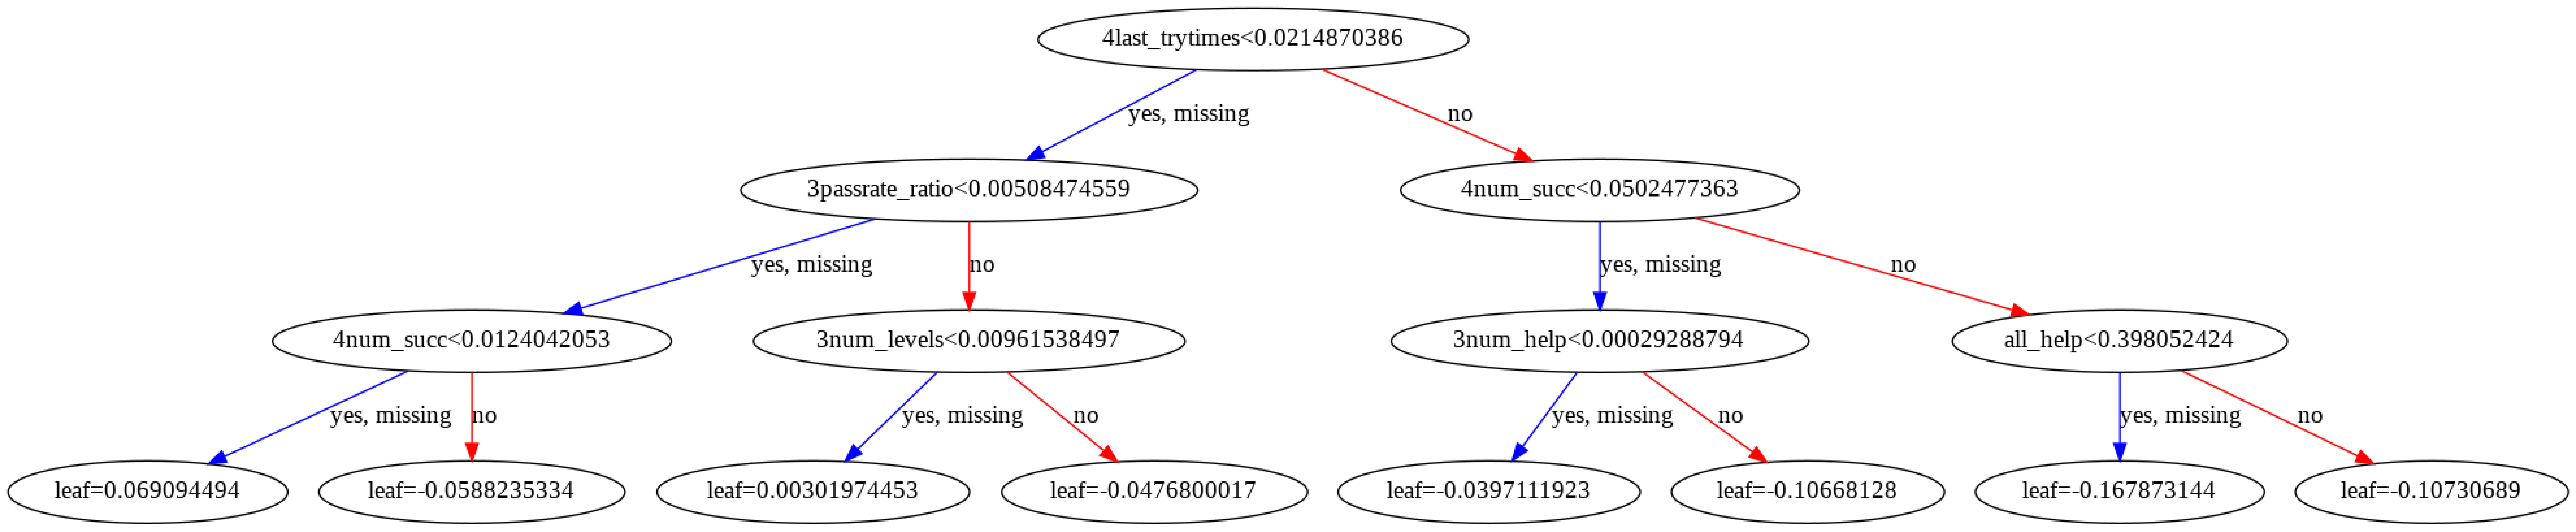

In [ ]:
def create_feature_map(features):
    outfile = open('clf.fmap','w')
    for i,f in enumerate(features):
        outfile.write('{0}\t{1}\tq\n'.format(i,f))
    outfile.close()
create_feature_map(train_feature_df.columns[3:])

import xgboost as xgb
import matplotlib.pyplot as plt
xgb.plot_tree(model, num_trees=0, fmap='clf.fmap')
fig = plt.gcf()
fig.set_size_inches((240, 240))
# fig.savefig('tree.png')

In [ ]:
proba = model.predict_proba(X_test)[:, 1]

In [ ]:
from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(X_train, y_train)
X_test = test_feature_df[new_feature_names].values
X_test = scaler.transform(X_test)
proba = model.predict_proba(X_test)[:, 1]

In [ ]:
proba.shape

(2773,)

In [ ]:
output=pd.DataFrame({'user_id':test_df.user_id,'proba':proba})
output.to_csv('/content/drive/MyDrive/Colab Notebooks/xtzx/proj/result.csv', index=None) 

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV  # Perforing grid search

train = lgb.Dataset(train_x, train_y)
valid = lgb.Dataset(valid_x, valid_y, reference=train)


parameters = {
              'max_depth': [1, 2, 3, 4, 5, 6, ],
              # #               # 7, 8, 9, 10, 15,20, 25, 30, 35],
              # 'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.15],
              # 'feature_fraction': [0.6, 0.7, 0.8, 0.9, 0.95],
              # 'bagging_fraction': [0.6, 0.7, 0.8, 0.9, 0.95],
              # 'bagging_freq': [2, 4, 5, 6, 8],
              # 'lambda_l1': [0, 0.1, 0.4, 0.5, 0.6],
              # 'lambda_l2': [0, 10, 15, 35, 40],
              # 'cat_smooth': [1, 10, 15, 20, 35]
}
gbm = lgb.LGBMClassifier(boosting_type='gbdt',
                         objective = 'binary',
                         metric = 'auc',
                         verbose = 0,
                         max_depth = 3,
                         learning_rate = 0.02,
                         num_leaves = 35,
                         feature_fraction=0.6,
                         bagging_fraction= 0.7,
                         bagging_freq= 6,
                         lambda_l1= 0,
                         lambda_l2= 10,
                         cat_smooth = 1)
#有了gridsearch我们便不需要fit函数
gsearch = GridSearchCV(gbm, param_grid=parameters, scoring='accuracy', cv=3)
gsearch.fit(train_x, train_y)

print("Best score: %0.3f" % gsearch.best_score_)
print("Best parameters set:")
best_parameters = gsearch.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))


Best score: 0.757
Best parameters set:
	max_depth: 4


In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV  # Perforing grid search

train = lgb.Dataset(train_x, train_y)
valid = lgb.Dataset(valid_x, valid_y, reference=train)


parameters = {
    # 'eta': [0.00001, 0.0001, 0.0005, 0.001, 
            # 0.005, 0.01, 0.02, 
            # 0.05, 0.1, 0.15, 0.2
            # ],
    # 'max_depth': [2, 3,
                  # 4, 5, 6, 7, 10, 15
                  # ]
    'alpha': [0, 0.1, 0.4, 0.5, 0.6],
    # 'lambda': [0, 10, 15, 35, 40]
}
gbm = XGBClassifier(
    eta = 0.001,
    max_depth = 2,
    alpha = 0,
    # lambda = 1
)
#有了gridsearch我们便不需要fit函数
gsearch = GridSearchCV(gbm, param_grid=parameters, scoring='roc_auc', cv=3)
gsearch.fit(train_x, train_y)

print("Best score: %0.3f" % gsearch.best_score_)
print("Best parameters set:")
best_parameters = gsearch.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: 0.802
Best parameters set:
	alpha: 0
